
> *Joamerson Islan Santos Amaral*



## Atividade 1 - Limpeza de dados

Iremos iniciar a atividade 1 fazendo o básico para qualquer projeto Pandas: importar a biblioteca e transformar nossos dados brutos, que estão no formato `.csv`, para uma estrutura padrão da biblioteca, chamada DataFrame, a qual utilizaremos durante todo o projeto. Como o nosso projeto lida com mais de uma tabela `.csv`, inicialmente iremos importar cada uma para um DataFrame separado, através do método `.read_csv()`.

In [ ]:
# Importação da biblioteca através de um alias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from scipy import stats

turmas2023_1 = pd.read_csv("turmas-2023.1.csv", sep=";")
turmas2023_2 = pd.read_csv("turmas-2023.2.csv", sep=";")
turmas2024_1 = pd.read_csv("turmas-2024.1.csv", sep=";")
turmas2024_2 = pd.read_csv("turmas-2024.2.csv", sep=";")

Agora, cada tabela de período letivo com a qual estamos trabalhando está contida em um DataFrame. No entanto, trabalhar com estes dados de forma separada não faz sentido, tendo em vista que estamos trabalhando com um grande conjunto de dados que se referem a mesma coisa (turmas da UFRN). Pode-se dizer que estamos trabalhando com pequenas tabelas que fazem parte de uma tabela maior (tabela contendo todas as turmas da UFRN).
Sendo assim, faz bastante sentido que concatenemos estes objetos em um novo DataFrame maior. Para tal, podemos utilizar o método `.concat()`, especificando quais DataFrames devem ser concatenados.

In [ ]:
df = pd.concat([turmas2023_1, turmas2023_2, turmas2024_1, turmas2024_2])

Agora que temos nosso verdadeiro DataFrame de trabalho armazenado em `df`, podemos rodar o método `.info()` para obtermos algumas informações sobre a tabela e checar se a concatenação foi bem sucedida.

In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 60116 entries, 0 to 14720
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_turma                   60116 non-null  int64  
 1   codigo_turma               60116 non-null  object 
 2   siape                      58785 non-null  float64
 3   matricula_docente_externo  1330 non-null   float64
 4   observacao                 1727 non-null   object 
 5   id_componente_curricular   60116 non-null  int64  
 6   ch_dedicada_periodo        60116 non-null  int64  
 7   nivel_ensino               60116 non-null  object 
 8   campus_turma               47449 non-null  object 
 9   local                      59773 non-null  object 
 10  ano                        60116 non-null  int64  
 11  periodo                    60116 non-null  int64  
 12  data_inicio                60116 non-null  object 
 13  data_fim                   60116 non-null  object 


None

Podemos notar de antemão que a quantidade de dados não nulos em cada uma das tabelas é discrepante, o que pode causar problemas futuros quando estivermos utilizando estes dados de forma estatística. Sendo assim, precisaremos realizar alguns tratamentos para obtermos um resultado mais preciso e agradável.

Sabendo que o sistema de dados abertos da UFRN possui um [dicionário de dados](https://dados.ufrn.br/dataset/1938623d-fb07-41a4-a55a-1691f7c3b8b5/resource/df95f48f-02b7-422f-a83c-17387842cbb4/download/dicionario-de-dados---turmas.pdf), onde são informados os nomes de cada campo, sua utilidade e seu tipo, podemos fazer uma comparação entre os tipos vistos aqui na nossa tabela e os tipos esperados pelo documento normalizador.


##### Listagem de inconsistências
"Campo: *Tipo atual* -> *Tipo esperado*"
*   `siape`: `float` -> `int`
*   `matricula_docente_externo`: `float` -> `int`
*   `data_inicio`: `object` -> `datetime`
*   `data_fim`: `object` -> `datetime`
*    `total_solicitacoes`: `float` -> `int`
*    `capacidade_aluno`: `float` -> `int`
*    `tipo`: `object` -> `int`
*    `data_consolidacao`: `object` -> `datetime`
*  `id_turma_agrupadora`: `float` -> `int`
*  `qtd_aulas_lancadas`: `float` -> `int`
*  `convenio`: `float` -> `object`



É possível perceber que há também uma inconsistência de nomes de campos:

"*Campo atual* -> *Campo correto*"


*   `id_componente_curricular` -> `id_componente`
*   `descricao_horario` -> `descricao_horário`

- - -
###### Comentário


> Apesar de esta segunda inconsistência estar presente, acredito que não seja uma boa prática colocar um acento em um nome de coluna que não possui um. Por este motivo, essa segunda inconsistênica não será tratada.




### Iniciando o tratamento de dados

#### Removendo registros duplicados

Com todas estas inconsistências listadas, podemos prosseguir para iniciar o tratamento de dados.
Começaremos checando por registros duplicados na tabela e removendo-os, uma vez que a duplicação em nada contribui para o conjunto de dados final. Para isso, checaremos inicialmente a quantidade de registros duplicados em nosso DataFrame.

In [ ]:
display(df.duplicated().value_counts())

,count
False,59148
True,968


Como podemos ver, há 968 registros duplicados em nosso DataFrame. Para removê-los, utilizaremos o método `.drop_duplicates()`.

In [ ]:
df = df.drop_duplicates()
display(df.duplicated().value_counts())

,count
False,59148


Após checar novamente, constatamos que não há mais registros duplicados, o que significa que podemos prosseguir com nossa limpeza.

### Alterando tipo de dados

#### Campo `siape`

Uma coisa que podemos ver de início é que os campos da coluna `siape` estão sendo representadas como um dado de ponto flutuante `float`, pelo fato de seus valores sempre terminarem com ".0".
O Dicionário de Dados fornecido aponta que o tipo deste dado deve ser `integet`, não `float`. Por este motivo, iremos processar os dados dessa coluna para remover essa inconsistência.

- - -
###### Comentário
> Um problema que consigo enxergar é o de haver uma comunicação entre essas tabelas que estamos trabalhando e outras tabelas advindas de outros lugares da UFRN. Se o campo `siape` for utilizado como chave estrangeira para se referenciar a uma outra tabela, e esta tabela também estiver com as mesmas inconsistências que estamos vendo aqui, é provável que a junção não seja bem sucedida, uma vez que uma das tabelas terá o campo `siape` com o tipo `integer` e a outra terá como `float`.
Apesar disso, acredito que o intuito seja realizar essa mudança para ficar condizente com o que foi especificado no manual.





In [ ]:
display(df['siape'].head())

,siape
0,1174208.0
1,1174208.0
2,1174208.0
3,1812476.0
4,1812476.0


Para iniciar nosso tratamento, precisamos primeiro checar se há valores nulos presentes na coluna `siape`. O motivo para isso é que o tipo de dado `int` não lida bem com valores nulos. Sendo assim, erros podem acontecer ao tentar realizar uma conversão direta entre ambos os tipos.
Para checar a quantidade de nulos na coluna, utilizaremos o método `.isna()` em conjunto com o método `.sum()`

In [ ]:
print(df['siape'].isna().sum())

1329


Como podemos ver, há 1329 valores nulos na coluna `siape`. Preencheremos estes valores com `0` para podermos realizar nossa conversão. Para tal, utilizaremos o método `.fillna()`.
- - -
###### Comentário


> É uma boa prática deixar explícito qual o valor de placeholder está sendo utilizado nestes casos, pois ajuda no processo de documentação e também auxilia futuramente pessoas que forem utilizar o conjunto de dados a tomar decisões.



In [ ]:
df['siape'] = df['siape'].fillna(0)
print(df['siape'].isna().sum())

0


Agora que não temos mais valores nulos, podemos realizar a conversão entre os tipos `float` e `int`. Para isso, utilizaremos o método `.astype()`.

In [ ]:
df['siape'] = df['siape'].astype(int)
display(df['siape'].head())

,siape
0,1174208
1,1174208
2,1174208
3,1812476
4,1812476


Como podemos ver, a coluna `siape` sumiu com seu ponto flutuante, o que significa que a conversão foi bem sucedida!

#### Campo `matricula_docente_externo`

A conversão do campo `matricula_docente_externo` seguirá a mesma lógica do anterior, pois se trata da mesma conversão `float` -> `int`.
- - -
###### Comentário


> É perceptível, como mostrado no código abaixo, que há uma baixa quantidade de registros realmente populados com dados não nulos na coluna `matricula_docente_externo`, o que pode induzir a uma deleção dessa coluna. No entanto, acredito que a alternativa mais condizente é a de manter a coluna e apenas colocar um valor *placeholder* igual a 0 para os 57820 casos nulos, tendo em vista que não sabemos exatamente ainda se utilizaremos esse campo na nossa análise futura. Sendo assim, converteremos a coluna para o tipo de dado correto e, futuramente, sendo necessário, excluiremos ela.



In [ ]:
print("Registros não nulos: ", df['matricula_docente_externo'].count())
print("Registros nulos: ", df['matricula_docente_externo'].isna().sum())

Registros não nulos:  1328
Registros nulos:  57820


Para realizar a conversão, faremos a mesma análise que fizemos com o campo `siape`.

In [ ]:
# Para constatar que há valores nulos na tabela
print(df['matricula_docente_externo'].isna().sum())

# Para preencher esses campos com valor placeholder de 0.
df['matricula_docente_externo'] = df['matricula_docente_externo'].fillna(0)

# Para converter o tipo de dado da coluna
df['matricula_docente_externo'] = df['matricula_docente_externo'].astype(int)

57820


In [ ]:
display(df['matricula_docente_externo'].head())

,matricula_docente_externo
0,0
1,0
2,0
3,0
4,0


Agora, temos nosso campo `matricula_docente_externo` com o tipo de dado correto!

#### Campo `data_inicio`

O campo `data_inicio` está atualmente definido como `object`, que é um tipo de dado genérico. O dicionário de dados da UFRN nos orienta a definir essa coluna como sendo um tipo de data. No pandas, esse tipo de dado é o `datetime`

In [ ]:
display(df['data_inicio'])

,data_inicio
0,2023/02/27 00:00:00.000
1,2023/02/27 00:00:00.000
2,2023/02/27 00:00:00.000
3,2023/02/27 00:00:00.000
4,2023/02/27 00:00:00.000
...,...
14716,2024/10/07 00:00:00.000
14717,2024/09/16 00:00:00.000
14718,2024/12/17 00:00:00.000
14719,2024/12/17 00:00:00.000


Para realizarmos a conversão, utilizaremos a função `.to_datetime`, especificando o campo em questão.

In [ ]:
df['data_inicio'] = pd.to_datetime(df['data_inicio'])
display(df['data_inicio'])

,data_inicio
0,2023-02-27
1,2023-02-27
2,2023-02-27
3,2023-02-27
4,2023-02-27
...,...
14716,2024-10-07
14717,2024-09-16
14718,2024-12-17
14719,2024-12-17


Agora temos o campo `data_inicio` definido com o tipo de dado correto!

#### Campo `data_fim`
Este campo está com o mesmo problema do campo anterior, `data_inicio`. Sendo assim, utilizaremos novamente a função `.to_datetime()` para realizar a conversão.

In [ ]:
df['data_fim'] = pd.to_datetime(df['data_fim'])
display(df['data_fim'])

,data_fim
0,2023-07-01
1,2023-07-01
2,2023-07-01
3,2023-07-01
4,2023-07-01
...,...
14716,2024-10-18
14717,2025-01-30
14718,2024-12-18
14719,2024-12-18


#### Campo `total_solicitacoes`

A conversão do campo `total_solicitacoes` segue a mesma da do campo `siape`, com uma pequena diferença. Aqui, se colocarmos o placeholder como sendo o valor 0, podemos estar contaminando um conjunto de dados que foi explicitamente definido como 0 com um outro conjunto de dados que está sendo 0 por decisão do cientista de dados. Portanto, para realizar uma melhor distinção entre os dados verdadeiros, utilizaremos o placeholder -1, pois, naturalmente, uma turma não pode ter solicitações negativas.

In [ ]:
print(df['total_solicitacoes'].isna().sum()) # Checagem

df['total_solicitacoes'] = df['total_solicitacoes'].fillna(-1) # Preenchimento

df['total_solicitacoes'] = df['total_solicitacoes'].astype(int) # Conversão

5735


In [ ]:
display(df['total_solicitacoes'].head())

,total_solicitacoes
0,-1
1,-1
2,-1
3,-1
4,-1


Agora, temos nosso campo `total_solicitacoes` com o tipo de dado correto!

#### Campo `capacidade_aluno`
Ao observar o dicionário de dados, percebemos que o campo `capacidade_aluno` é um campo obrigatório, o que significa que ele precisa ser expresso de forma explícita. Isso nos indica que, muito provavelmente, não poucos ou nenhum valor nulo presentes na sua coluna. Para constatar isso, podemos verificar da mesma forma com que fizemos anteriormente.

In [ ]:
print(df['capacidade_aluno'].isna().sum())

226


Como podemos ver, há apenas 226 registros nulos. Isto significa que boa parte da tabela está populada. Preencheremos os espaços vazios com o *placeholder* -1.

In [ ]:
print(df['capacidade_aluno'].isna().sum()) # Checagem

df['capacidade_aluno'] = df['capacidade_aluno'].fillna(-1) # Preenchimento

df['capacidade_aluno'] = df['capacidade_aluno'].astype(int) # Conversão

226


In [ ]:
display(df['capacidade_aluno'].head())

,capacidade_aluno
0,1
1,1
2,1
3,1
4,1


#### Campo `tipo`
Alguns registros do campo `tipo` podem ser visualizados abaixo:

In [ ]:
display(df['tipo'].head())

,tipo
0,REGULAR
1,REGULAR
2,REGULAR
3,REGULAR
4,REGULAR


É evidente que trata-se de um campo que está sendo preenchido com textos ao invés de números. Apesar de o dicionário recomendar a conversão, ele não deixa explícito quais valores numéricos correspondem a cada situação de turma.
Por exemplo:
`1 = "REGULAR"`
`2 = "FÉRIAS"`
`3 = "ENSINO INDIVIDUAL`
Pelo fato de isto não estar especificado, optarei por não realizar quaisquer alterações no tipo desse dado.
No entanto, podemos ainda fazer alguns procedimentos para garantir que os valores inseridos serão realmente condizentes com a realizade. Um exemplo disso é retirar espaços vazios no início das strings e fixar o conteúdo em caixa alta para que valores como "rEgUlar" ou "férias" não seja possível. Para tal, utilizaremos o recurso de modificação de *strings* padrão do Pandas.

In [ ]:
df['tipo'] = df['tipo'].str.strip() # Remoção de espaços
df['tipo'] = df['tipo'].str.upper() # Forçar caixa alta

Agora que todo o nosso conjunto de dados está com um padrão de formatação, podemos utilizar o método `.replace()` para garantir que a opção "FERIAS" (sem o acento agudo) não seja permitido.

In [ ]:
df['tipo'] = df['tipo'].str.replace("FERIAS", "FÉRIAS")

Desta forma, o campo `tipo` está melhor formatado e pronto para o uso.

#### Campo `data_consolidacao`
Assim como nos campos de `data_inicio` e `data_fim`, utilizaremos o método de conversão padrão para datas oferecido pela biblioteca Pandas.

In [ ]:
df['data_consolidacao'] = pd.to_datetime(df['data_consolidacao'])
display(df['data_consolidacao'])

,data_consolidacao
0,2023-07-21 10:59:04.285
1,2023-07-21 10:53:20.671
2,2023-07-21 10:57:36.425
3,2023-07-10 09:14:34.285
4,2023-07-10 09:13:43.535
...,...
14716,NaT
14717,2025-03-07 10:31:15.291
14718,NaT
14719,NaT


#### Campo `agrupadora`

Antes de tentarmos realizar uma conversão no campo `id_turma_agrupadora`, vamos obeservar um pouco melhor no conteúdo desta outra coluna, `agrupadora`.

In [ ]:
display(df['agrupadora'].head(10))
print(f"A coluna 'agrupadora' possui {df['agrupadora'].sum()} valores True")

,agrupadora
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


A coluna 'agrupadora' possui 0 valores True


Como podemos ver, a coluna `agrupadora` está inteiramente populada com valores 0. Isto significa que a sua existência é completamente descartável dentro do contexto em que estamos trabalhando. Não faz sentido realizar uma conversão de tipos aqui pois o conjunto de dados inteiro é inútil. Sendo assim, é plausível tomar a decisão de apagar esta coluna. Podemos fazer isso através do método `.drop()`.

In [ ]:
df.drop('agrupadora', axis=1, inplace=True)
# "axis=1" para definir eixo das colunas
# "inplace=True" para realizar sobrescrita direta


Com isso feito, a coluna `agrupadora` foi removida com sucesso!

#### Campo `id_turma_agrupadora`
Como o campo `id_turma_agrupadora` dependia do campo `agrupadora` e o campo `agrupadora` foi removido, este campo também pode ser removido.

In [ ]:
df.drop('id_turma_agrupadora', axis=1, inplace=True)

#### Campo `qtd_aulas_lancadas`
Esta é uma conversão novamente semelhante a do campo `siape`. Realizaremos novamente o procedimento, substituindo os valores nulos pelo valor -1, para não misturá-los com dados explicitamente definidos.

In [ ]:
print(df['qtd_aulas_lancadas'].isna().sum()) # Checagem

df['qtd_aulas_lancadas'] = df['qtd_aulas_lancadas'].fillna(-1) # Preenchimento

df['qtd_aulas_lancadas'] = df['qtd_aulas_lancadas'].astype(int) # Conversão

3408


#### Campo `convenio`

Antes de considerarmos fazer a conversão de tipos, vamos dar uma olhada melhor nesse campo.

In [ ]:
display(df['convenio'].head(10))
print("Quantidade de registros não nulos: ", df['convenio'].notna().sum())

,convenio
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


Quantidade de registros não nulos:  0


Como podemos ver, toda a coluna `convenio` é composta por itens nulos, o que não agrega em nada na análise de dados futura que faremos. Sendo assim, podemos realizar a sua deleção sem preocupações.

In [ ]:
df.drop('convenio', axis=1, inplace=True)

#### Campo `id_componente_curricular`
Conforme discutido anteriormente, o dicionário de dados propõe o rótulo `id_componente` para esta coluna. Sendo assim, devemos alterá-la para obter uma maior proximidade com as especificações fornecidas. Para isto, utilizaremos o método `.rename()`.

In [ ]:
df.rename(columns={
    'id_componente_curricular': 'id_componente'
}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59148 entries, 0 to 14720
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id_turma                   59148 non-null  int64         
 1   codigo_turma               59148 non-null  object        
 2   siape                      59148 non-null  int64         
 3   matricula_docente_externo  59148 non-null  int64         
 4   observacao                 1725 non-null   object        
 5   id_componente              59148 non-null  int64         
 6   ch_dedicada_periodo        59148 non-null  int64         
 7   nivel_ensino               59148 non-null  object        
 8   campus_turma               46609 non-null  object        
 9   local                      58805 non-null  object        
 10  ano                        59148 non-null  int64         
 11  periodo                    59148 non-null  int64         
 12  data_inic

Como podemos ver, agora o campo está com o seu nome corrigido.

#### Campo `observacao`

In [ ]:
print("Elementos não nulos: ", df['observacao'].count())
print("Elementos nulos: ", df['observacao'].isna().sum())

Elementos não nulos:  1725
Elementos nulos:  57423


Podemos ver que o campo `observacao` possui poucos elementos não nulos, em comparação com o número total de registros. Isto significa que, para a nossa análise, estes dados não serão tão importantes. Dessa forma, podemos realizar a remoção dessa coluna.

In [ ]:
df.drop('observacao', axis=1, inplace=True)

In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59148 entries, 0 to 14720
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id_turma                   59148 non-null  int64         
 1   codigo_turma               59148 non-null  object        
 2   siape                      59148 non-null  int64         
 3   matricula_docente_externo  59148 non-null  int64         
 4   id_componente              59148 non-null  int64         
 5   ch_dedicada_periodo        59148 non-null  int64         
 6   nivel_ensino               59148 non-null  object        
 7   campus_turma               46609 non-null  object        
 8   local                      58805 non-null  object        
 9   ano                        59148 non-null  int64         
 10  periodo                    59148 non-null  int64         
 11  data_inicio                59148 non-null  datetime64[ns]
 12  data_fim 

None

#### Campo `campus_turma`

In [ ]:
display(df['campus_turma'].value_counts())

,count
campus_turma,
Campus Central,37979
Campus Caicó,4516
Campus Santa Cruz,2820
Campus Macaíba,664
Campus Currais Novos,630


Sabendo que o Campus Central é o valor que mais aparece neste conjunto de dados, podemos substituir os dados faltantes com este valor, sem que isso tenha uma grande perda para a nossa análise futura. Podemos fazer isso novamente através do método `.fillna()`

In [ ]:
df['campus_turma'] = df['campus_turma'].fillna("Campus Central")
display(df['campus_turma'].value_counts())

,count
campus_turma,
Campus Central,50518
Campus Caicó,4516
Campus Santa Cruz,2820
Campus Macaíba,664
Campus Currais Novos,630


In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59148 entries, 0 to 14720
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id_turma                   59148 non-null  int64         
 1   codigo_turma               59148 non-null  object        
 2   siape                      59148 non-null  int64         
 3   matricula_docente_externo  59148 non-null  int64         
 4   id_componente              59148 non-null  int64         
 5   ch_dedicada_periodo        59148 non-null  int64         
 6   nivel_ensino               59148 non-null  object        
 7   campus_turma               59148 non-null  object        
 8   local                      58805 non-null  object        
 9   ano                        59148 non-null  int64         
 10  periodo                    59148 non-null  int64         
 11  data_inicio                59148 non-null  datetime64[ns]
 12  data_fim 

None

#### Campo `descricao_horario`

Criaremos uma função que será responsável por preencher os valores de vazios de strings baseados nos seus outros valores já preenchidos, de forma proporcional.

In [ ]:
def preencher_dados_proporcionalmente(df, coluna):
    # Código gerado com auxílio de I.A.

    # Verifica se a coluna existe no DataFrame
    if coluna not in df.columns:
        raise ValueError(f"A coluna '{coluna}' não existe no DataFrame.")

    # Cria uma cópia do DataFrame para não modificar o original
    df = df.copy()

    # Obtém os valores não nulos
    valores_validos = df[coluna].dropna()

    # Se não houver valores válidos, retorna o DataFrame sem alterações
    if len(valores_validos) == 0:
        return df

    # Calcula as proporções de cada valor único
    proporcoes = valores_validos.value_counts(normalize=True)

    # Gera valores aleatórios baseados nas proporções para preencher os NaN
    valores_para_preencher = np.random.choice(
        proporcoes.index,
        size=df[coluna].isna().sum(),
        p=proporcoes.values
    )

    # Preenche os valores NaN
    df.loc[df[coluna].isna(), coluna] = valores_para_preencher

    return df

In [ ]:
display(df['descricao_horario'].value_counts())

,count
descricao_horario,
3T1234,525
2N1234,375
3M234,335
35T34,331
35T56,329
...,...
"7M12345 7T2345 (11/01/2025 - 11/01/2025), 7M234 (18/01/2025 - 18/01/2025)",1
"4T3456 (18/12/2024 - 18/12/2024), 6N1234 (20/12/2024 - 20/12/2024)",1
467M123456 5M16 467T123456 5T12345 4567N1234,1


Vamos preencher os valores proporcionalmente àqueles encontrados aqui.

In [ ]:
df = preencher_dados_proporcionalmente(df, 'descricao_horario')

#### Campo `local`

In [ ]:
display(df['local'].value_counts())

,count
local,
HUOL,3896
"HUOL, LIGA, WALFREDO GURGEL E HOSPITAL DA POLICIA.",1788
EMCM,1628
DPEDI/HUOL/MEJC,1272
DOD,1054
...,...
Bloco BSI - Sala II,1
Ppgg,1
Alunos de Mestrado da profª Selma,1


Iremos preencher os espaços vazios proporcionalmente àqueles já inseridos.

In [ ]:
df = preencher_dados_proporcionalmente(df, 'local')

#### Campo `data_consolidacao`

In [ ]:
display(df['data_consolidacao'].value_counts())

,count
data_consolidacao,
2024-07-31 23:13:20.257,33
2024-07-31 23:01:46.338,33
2025-01-29 11:34:26.866,33
2024-07-31 23:27:54.786,33
2025-01-29 11:50:06.687,33
...,...
2023-07-17 23:43:10.625,1
2023-07-18 12:28:14.592,1
2025-02-24 08:11:25.073,1


Preencheremos os valores faltantes proporcionalmente àqueles já inseridos.

In [ ]:
df = preencher_dados_proporcionalmente(df, 'data_consolidacao')

In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59148 entries, 0 to 14720
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id_turma                   59148 non-null  int64         
 1   codigo_turma               59148 non-null  object        
 2   siape                      59148 non-null  int64         
 3   matricula_docente_externo  59148 non-null  int64         
 4   id_componente              59148 non-null  int64         
 5   ch_dedicada_periodo        59148 non-null  int64         
 6   nivel_ensino               59148 non-null  object        
 7   campus_turma               59148 non-null  object        
 8   local                      59148 non-null  object        
 9   ano                        59148 non-null  int64         
 10  periodo                    59148 non-null  int64         
 11  data_inicio                59148 non-null  datetime64[ns]
 12  data_fim 

None

#### Campo `distancia`
Segundo o dicionário de dados, esse campo serve apenas para informar se a turma é ofertada na modalidade à distância ou não. Como este dado já pode ser extraído através do campo `modalidade_participantes`, esta coluna torna-se necessária para o objetivo que queremos. Sendo assim, é possível removê-la sem que haja um impacto negativo na tabela inteira
- - -
###### Comentário

> Este campo foi removido após a etapa de limpeza de dados.



In [ ]:
df.drop('distancia', axis=1, inplace=True)

#### Campo `local`
Este campo serve apenas para indicar qual o local de ocorrência das aulas de uma determinada turma. Como este campo não oferece informações interessantes que possam ser utilizadas na nossa análise, iremos realizar o *drop* desta coluna.
- - -
###### Comentário

> Este campo foi removido após a etapa de limpeza de dados.

In [ ]:
df.drop('local', axis=1, inplace=True)

#### Campo `situacao_turma`

Ao analisar o campo `situacao_turma`, percebemos que este resguarda alguns tipos de turma que não são interessantes para a nossa análise. São elas: `EXCLUÍDA` e `INTERROMPIDA`. Sendo assim, podemos livremente apagar os registros que possuem alguma das duas situações descritas acima.

In [ ]:
df = df[~df['situacao_turma'].isin(['EXCLUÍDA', 'INTERROMPIDA'])]
display(df['situacao_turma'].value_counts())

,count
situacao_turma,
CONSOLIDADA,56016
ABERTA,582


Agora que temos todos os nossos dados preenchidos corretamente, a etapa de limpeza de dados está concluída (por agora). É esperado que precisemos voltar para essa etapa no futuro para repensar algumas coisas e fazer alterações.

## Atividade 2 - Análise Exploratória de Dados
Agora que fizemos uma boa limpeza inicial em nossa estrutura de dados, chegou a hora de tentar extrair informações a partir delas. Uma boa forma de fazer isso é através de gráficos, pois facilitam a visualização da relação entre dados de tipos distintos, possibilitando que até pessoas que não tenham conhecimento aprofundado sobre ciência de dados possam visualizá-los de forma intuitiva.

### Análise Univariada
Para iniciar o nosso estudo das informações presentes na nossa tabela, podemos começar buscando formas de visualizar cada dado de forma separada. Para isso, pegaremos algumas colunas numéricas interessantes e plotaremos gráficos com o auxílio da biblioteca matplotlib.

#### Gráfico `ch_dedicada_periodo`

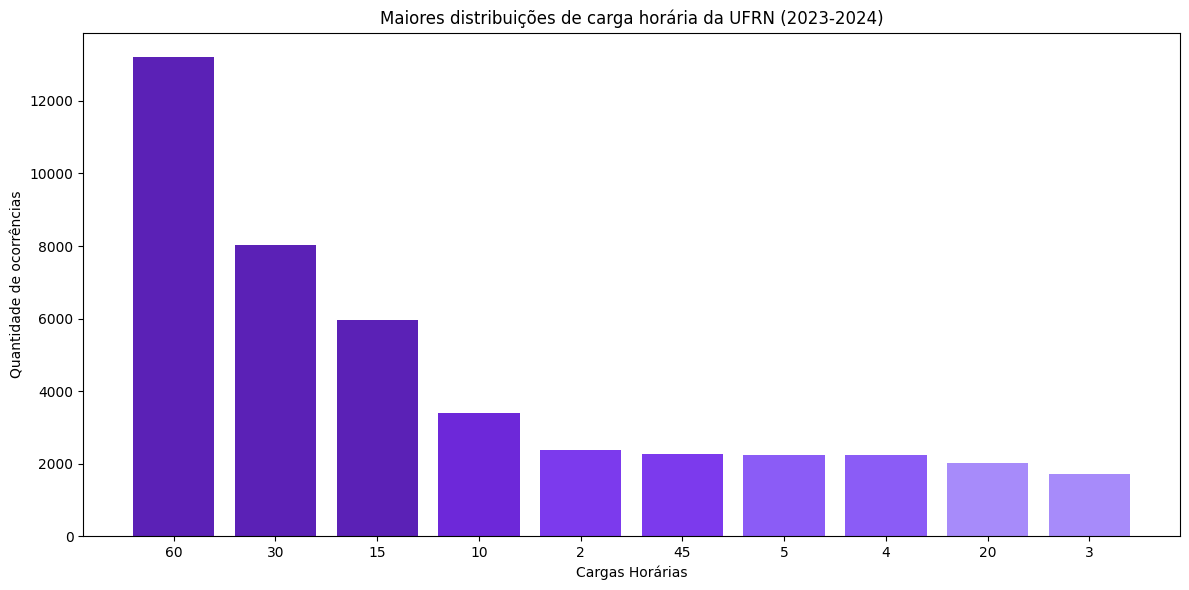

In [ ]:
# Pega as 20 cargas horárias que mais aparecem
ch_counts = df['ch_dedicada_periodo'].value_counts().nlargest(10)
colors = [
    "#5b21b6",
    "#5b21b6",
    "#5b21b6",
    "#6d28d9",
    "#7c3aed",
    "#7c3aed",
    "#8b5cf6",
    "#8b5cf6",
    "#a78bfa",
    "#a78bfa"
]

# Cria um gráfico de barra com as informações
plt.figure(figsize=(12, 6))
plt.bar(ch_counts.index.astype(str), ch_counts.values, color=colors)
plt.xlabel('Cargas Horárias')
plt.ylabel('Quantidade de ocorrências')
plt.title('Maiores distribuições de carga horária da UFRN (2023-2024)')

plt.tight_layout()
plt.show()

Com o gráfico acima, podemos ver que as cargas horárias de 60 horas e 30 horas são as mais frequentes dentro da instituição. No entanto, o gráfico também mostra algumas cargas horárias pouco condizentes com a realidade, como disciplinas de 1 e 7 horas. Estes valores podem indicar uma má formatação ou má inserção de dados no sistema.

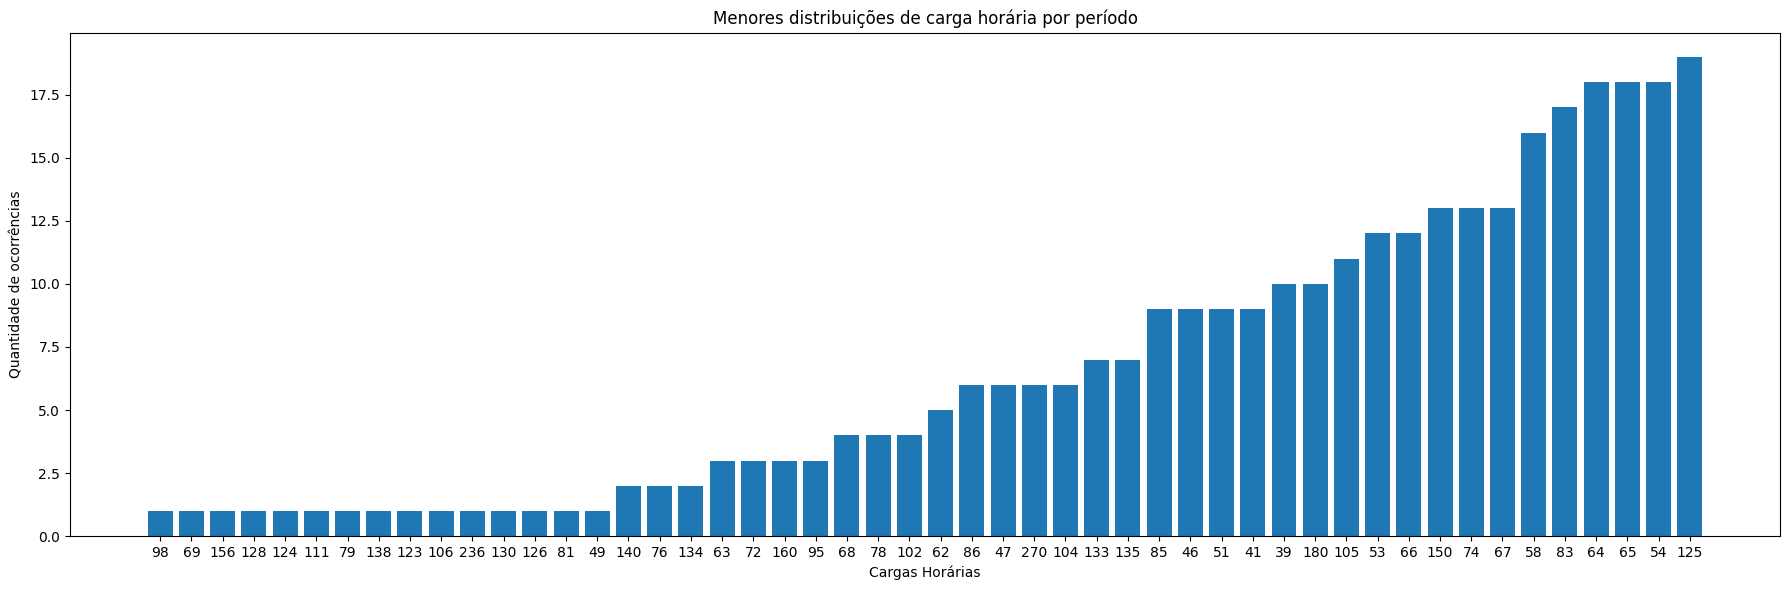

In [ ]:
# Pega as 20 cargas horárias que menos aparecem
ch_counts = df['ch_dedicada_periodo'].value_counts().nsmallest(50)

# Cria um gráfico de barra com as informações
plt.figure(figsize=(18, 6))
plt.bar(ch_counts.index.astype(str), ch_counts.values)
plt.xlabel('Cargas Horárias')
plt.ylabel('Quantidade de ocorrências')
plt.title('Menores distribuições de carga horária por período')

plt.tight_layout()
plt.show()

Como podemos ver no gráfico acima, as cargas horárias que menos aparecem ocorrem em quantidades extremamente raras se comparados à massa total de dados que temos disponível. Sendo assim, não precisamos nos preocupar com a análise destes casos.

#### Gráfico `campus_turma`

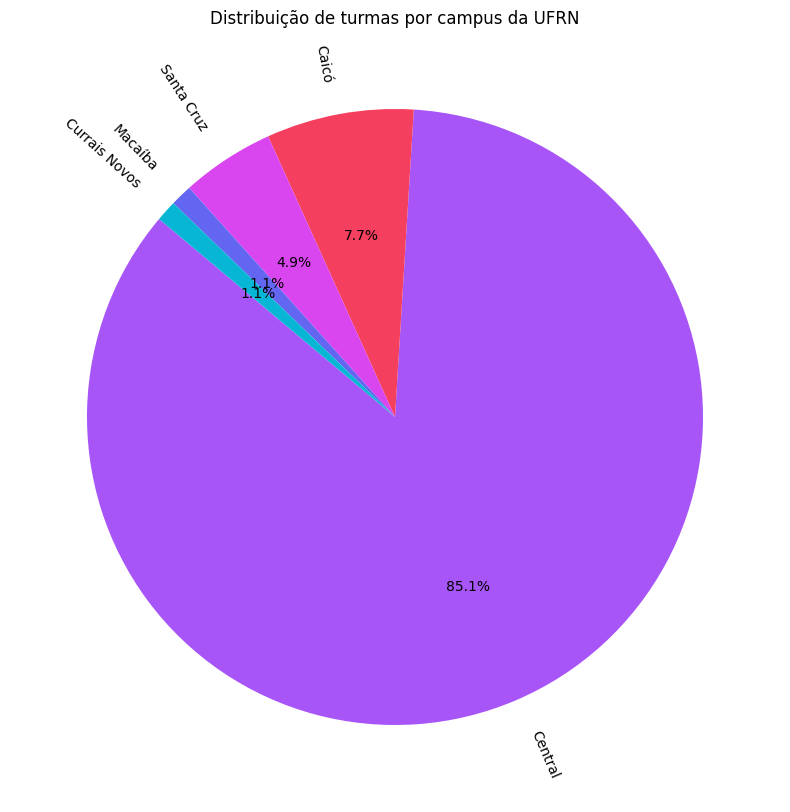

In [ ]:
campus_turma = df['campus_turma'].value_counts()

# Remove a palavra "Campus" dos labels
labels = [label.replace('Campus ', '') for label in campus_turma.index]
colors = [
      "#a855f7",
  "#f43f5e",
  "#d946ef",
  "#6366f1",
  "#06b6d4"

]

# Cria o gráfico do tipo pizza, rotacionando a imagem e seus labels
plt.figure(figsize=(10, 10))
plt.pie(campus_turma, labels=labels, autopct='%1.1f%%', startangle=140, rotatelabels=True, colors=colors)
plt.title('Distribuição de turmas por campus da UFRN')
plt.show()

Como podemos ver pelo gráfico de pizza, a distribuição de turmas da UFRN é bastante assimétrica, com quase 90% pertencendo ao Campus Natal Central, que é seguido pelo Campus Caicó e Campus Santa Cruz.

#### Gráfico `nivel_ensino`

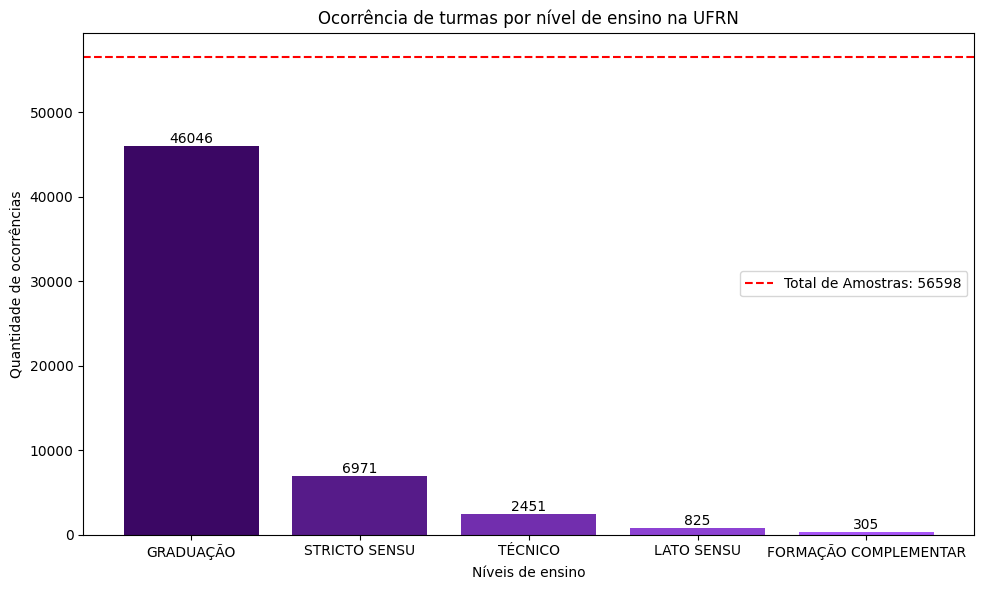

In [ ]:
# Pega os dados relativos ao nível de ensino
ch_counts = df['nivel_ensino'].value_counts()

# Calcula o número total de amostras
total_samples = df.shape[0]

# Cria um gráfico de barra com as informações
plt.figure(figsize=(10, 6))

# Define as cores para o gradiente
from matplotlib.colors import LinearSegmentedColormap
colors = ["#3b0764", "#a855f7"]
cmap = LinearSegmentedColormap.from_list("my_gradient", colors)

# Use o colormap customizado para atribuir cores a cada barra
bar_colors = cmap(np.linspace(0, 1, len(ch_counts)))

bars = plt.bar(ch_counts.index.astype(str), ch_counts.values, color=bar_colors)
plt.xlabel('Níveis de ensino')
plt.ylabel('Quantidade de ocorrências')
plt.title('Ocorrência de turmas por nível de ensino na UFRN')

# Adiciona valores reais no topo das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

# Adiciona uma linha horizontal indicando o limirar de valores
plt.axhline(y=total_samples, color='r', linestyle='--', label=f'Total de Amostras: {total_samples}')
plt.legend()

plt.tight_layout()
plt.show()

O gráfico acima exibe a ocorrência de turmas por nível de ensino da UFRN. É notável que grande parte das turmas são de graduação, compondo quase 80% das amostras totais.

#### Gráfico `modalidade_participantes`

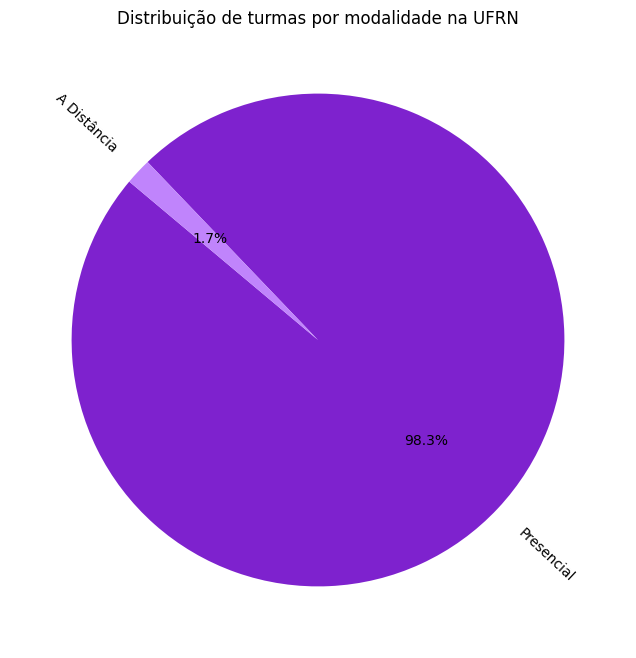

In [ ]:
modalidade_participantes = df['modalidade_participantes'].value_counts()

# Remove a palavra "Campus" dos labels
labels = [label.replace('Campus ', '') for label in modalidade_participantes.index]

plt.figure(figsize=(8, 8))

# Define as cores customizadas para as fatias
colors = ['#7e22ce', '#c084fc']

# Cria o gráfico do tipo pizza, rotacionando a imagem e seus labels
plt.pie(modalidade_participantes, labels=labels, autopct='%1.1f%%', startangle=140, rotatelabels=True, colors=colors)
plt.title('Distribuição de turmas por modalidade na UFRN')
plt.show()

O gráfico acima nos mostra que há quase uma totalidade de turmas ofertadas no modelo presencial de ensino, correspondendo a mais de 98% das turmas totais, enquanto as turmas na modalidade de ensino à distância compõem pouco mais de 1%.

#### Gráfico `data_inicio`

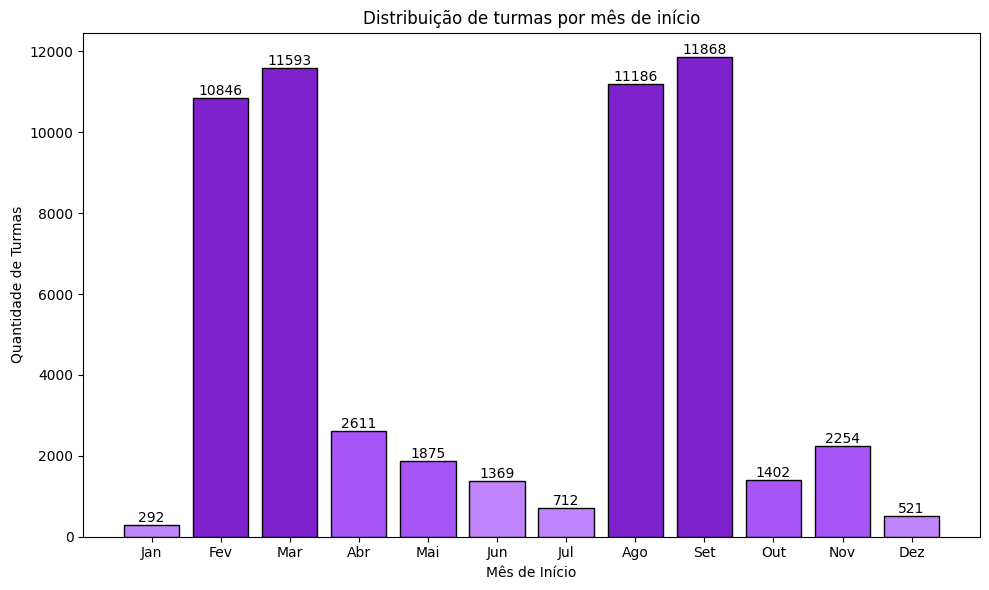

In [ ]:
import calendar
import locale
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extrai os meses de 'data_inicio'
months = df['data_inicio'].dt.month

# Conta a ocorrência de cada mês
month_counts = months.value_counts().sort_index()

# Cria um dicionário com a abreviação dos meses
portuguese_month_abbr = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}

# Cria o gráfico
plt.figure(figsize=(10, 6))
# Use a colormap to assign different colors to each bar
#colors = plt.cm.viridis(np.linspace(0, 1, len(month_counts)))
colors = [
    "#c084fc",
    "#7e22ce",
    "#7e22ce",
    "#a855f7",
    "#a855f7",
    "#c084fc",
    "#c084fc",
    "#7e22ce",
    "#7e22ce",
    "#a855f7",
    "#a855f7",
    "#c084fc"
]
bars = plt.bar(month_counts.index, month_counts.values, color=colors, edgecolor='black', linewidth=1)

plt.xlabel('Mês de Início')
plt.ylabel('Quantidade de Turmas')
plt.title('Distribuição de turmas por mês de início')

# Define o eixo x como sendo o eixo dos meses
plt.xticks(month_counts.index, [portuguese_month_abbr[i] for i in month_counts.index])

# Adiciona a quantidade de turmas acima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()

Olhando para o gráfico, é nítido que há uma maior criação de turmas durante os meses de fevereiro, março, agosto e setembro. A estes meses corresponde as datas normais de início de semestre, sendo os dois primeiros relativos ao primeiro semestre e os dois últimos relativos ao segundo semestre. Sendo assim, conclui-se que a grande maioria das turmas da UFRN são criadas antes ou pouco depois do início do período letivo.

### Análise Bivariada
#### Solicitações por capacidade de aluno
O gráfico a seguir mostra uma relação entre a capacidade de alunos de uma determinada turma e as solicitações de matrícula que esta turma recebeu.

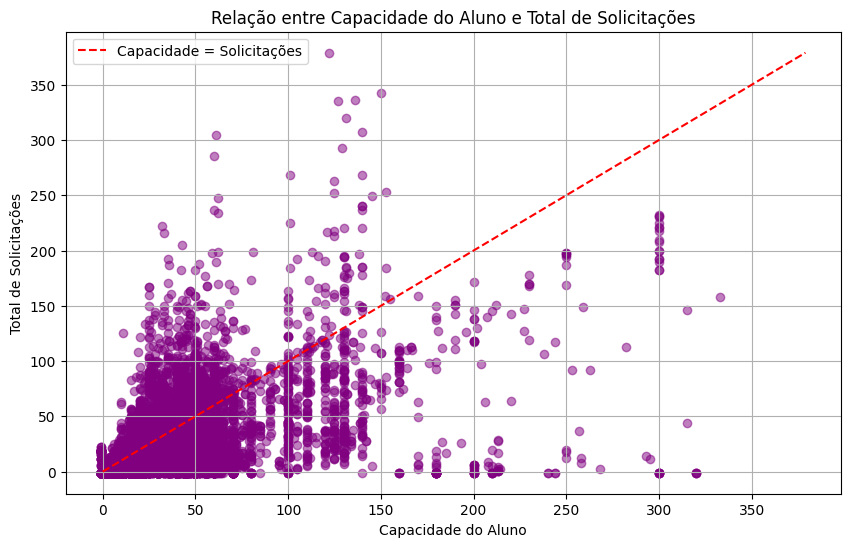

In [ ]:
def gerar_grafico_capacidade_solicitacoes():
  # Filtra os dados para remover outliers
  df_filtered = df[(df['capacidade_aluno'] < 400) & (df['total_solicitacoes'] < 400)].copy()

  plt.figure(figsize=(10, 6))
  plt.scatter(df_filtered['capacidade_aluno'], df_filtered['total_solicitacoes'], alpha=0.5, color='purple')
  plt.xlabel('Capacidade do Aluno')
  plt.ylabel('Total de Solicitações')
  plt.title('Relação entre Capacidade do Aluno e Total de Solicitações')

  # Adiciona a linha x = y
  max_value = max(df_filtered['capacidade_aluno'].max(), df_filtered['total_solicitacoes'].max())
  plt.plot([0, max_value], [0, max_value], 'r--', label='Capacidade = Solicitações')
  plt.legend()

  plt.grid(True)
  plt.show()

gerar_grafico_capacidade_solicitacoes()

É possível perceber que o gráfico mostra alguns valores muito distoantes, como salas com capacidade para mais de 400 alunos e solicitações que vão além de 400. Vamos dar uma olhada em quantos são estes casos para saber o que faremos com eles.

In [ ]:
turmas_acima_400 = df[df['capacidade_aluno'] >= 400]
print("Turmas com capacidade para mais de 400 alunos: ",len(turmas_acima_400))

solicitacoes_acima_400 = df[df['total_solicitacoes'] >= 400]
print("Turmas com mais de 400 solicitações: ", len(solicitacoes_acima_400))

Turmas com capacidade para mais de 400 alunos:  0
Turmas com mais de 400 solicitações:  0


Como podemos ver, os *outliers* neste caso representam uma fração ínfima do nosso conjunto de dados total. Sendo assim, não vale a pena tentar tratá-los de forma individual. Assim, removeremos estes registros e geraremos um novo gráfico.

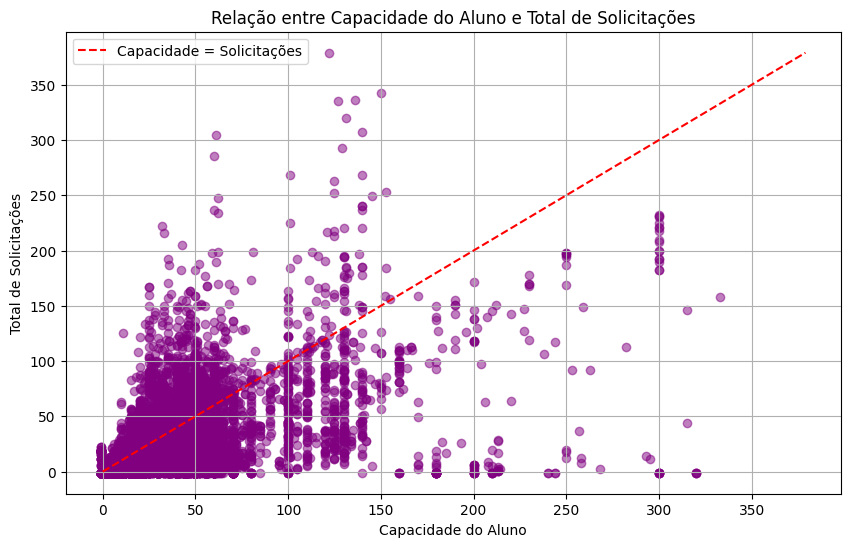

In [ ]:
df = df[df['capacidade_aluno'] < 400]
df = df[df['total_solicitacoes'] < 400]

gerar_grafico_capacidade_solicitacoes()

Agora que o gráfico está sem alguns *outliers*, conseguimos analisar ele melhor. Podemos ver, por exemplo, que salas que possuem capacidade para até 150 alunos geralmente possuem um número de solicitações maior do que a quantidade de vagas. No entanto, ao ultrapassar esse limite, a frequência de turmas com mais capacidade do que solicitações é recorrente. Isto pode indicar que estes dados de capacidade também foram gerados de forma incorreta.

##### Testando a hipótese
Se as turmas em questão tiverem sido geradas de forma incorreta, é esperado que a sua situação esteja como "EXCLUÍDA". Vamos testar essa hipótese através de uma filtragem com contagem de valores.

In [ ]:
filtro = df[df['capacidade_aluno'] >= 150]
display(filtro['situacao_turma'].value_counts())

,count
situacao_turma,
CONSOLIDADA,203


Como podemos ver, as turmas em que o fenômeno descrito acontece não estão listadas como excluídas, o que nos leva a acreditar que não se trata de um erro. Sendo assim, fica em aberto a motivação de tal comportamento estatístico.

#### Relação entre solicitações em turmas de docente interno e docente externo

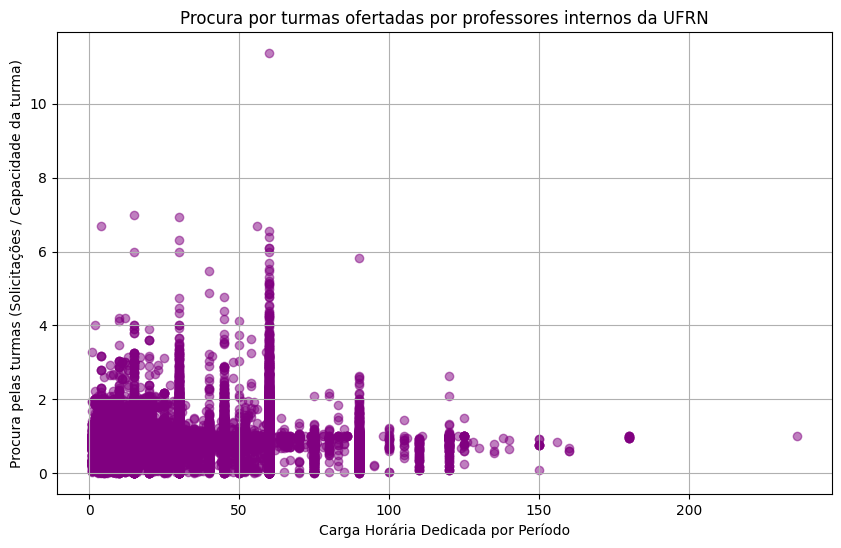

In [ ]:
# Filtra valores maiores que 0 para "total_solicitacoes" e "capacidade_aluno"
# Esses filtros precisam ser feitos pois, na fase de limpeza, definimos -1 como o placeholder para valores nulos
turmas_siape = df[(df['siape'] != 0) & (df['total_solicitacoes'] > 0) & (df['capacidade_aluno'] > 0)].copy()
turmas_siape['procura_media'] = turmas_siape['total_solicitacoes'] / turmas_siape['capacidade_aluno'] # Média de procura pelas turmas

plt.figure(figsize=(10, 6))
plt.scatter(turmas_siape['ch_dedicada_periodo'], turmas_siape['procura_media'], alpha=0.5, color='purple')
plt.xlabel('Carga Horária Dedicada por Período')
plt.ylabel('Procura pelas turmas (Solicitações / Capacidade da turma)')
plt.title('Procura por turmas ofertadas por professores internos da UFRN')
plt.grid(True)
plt.show()

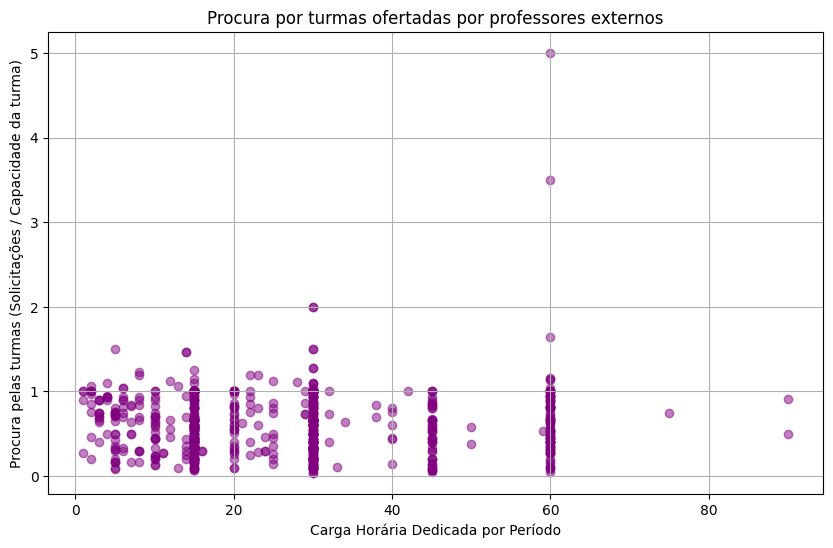

In [ ]:
# Filtra valores maiores que 0 para "total_solicitacoes" e "capacidade_aluno"
# Esses filtros precisam ser feitos pois, na fase de limpeza, definimos -1 como o placeholder para valores nulos
turmas_siape = df[(df['matricula_docente_externo'] != 0) & (df['total_solicitacoes'] > 0) & (df['capacidade_aluno'] > 0)].copy()
turmas_siape['procura_media'] = turmas_siape['total_solicitacoes'] / turmas_siape['capacidade_aluno'] # Média de procura pelas turmas

plt.figure(figsize=(10, 6))
plt.scatter(turmas_siape['ch_dedicada_periodo'], turmas_siape['procura_media'], alpha=0.5, color='purple')
plt.xlabel('Carga Horária Dedicada por Período')
plt.ylabel('Procura pelas turmas (Solicitações / Capacidade da turma)')
plt.title('Procura por turmas ofertadas por professores externos')
plt.grid(True)
plt.show()

Analisando ambos os gráficos acima, é possível constatar uma grande diferença entre a procura por turmas ofertadas por docentes internos da UFRN (que possuem SIAPE) e a procura por turmas ofertadas por docentes externos (que não possuem SIAPE). Enquanto as turmas dos professores internos têm uma razão de procura concentrada entre 2 e 4, as turmas ofertadas por docentes externos raramente ultrapassa a razão de procura 1. Este fato pode indicar uma certa preferência por docentes internos, possivelmente ocasionada pela familiaridade ou contato frequente dos discentes com certos profissionais da instituição.

#### Evolução da oferta de turmas por semestre

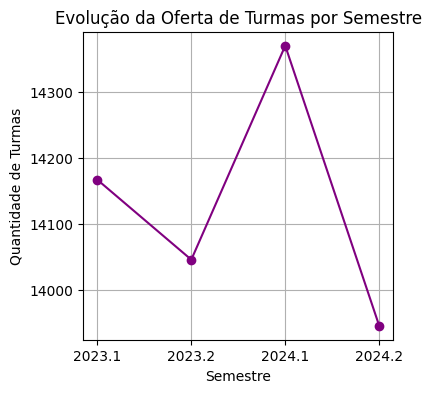

In [ ]:
df['semestre'] = df['ano'].astype(str) + '.' + df['periodo'].astype(str) # Define a coluna auxiliar "semestre"

turmas_por_semestre = df['semestre'].value_counts().sort_index() # Agrupa as turmas por semestre

plt.figure(figsize=(4, 4))
plt.plot(turmas_por_semestre.index, turmas_por_semestre.values, marker='o', linestyle='-', color='purple')
plt.xlabel('Semestre')
plt.ylabel('Quantidade de Turmas')
plt.title('Evolução da Oferta de Turmas por Semestre')
plt.grid(True)
plt.show()

O gráfico acima mostra a oferta de turmas dos últimos 4 semestres, que é o intervalo de dados que temos acesso. A primeira coisa interessante que podemos notar é que há uma oferta maior de turmas nos dois semestres iniciais de cada ano. Um motivo plausível para isso seria o fato de que mais estudantes da UFRN adentram durante o primeiro semestre letivo do ano. Sendo assim, há uma demanda maior por turmas e uma consequente oferta também maior.

O segundo fato interessante que pode ser observado é a discrepância entre a quantidade de turmas ofertadas no semestre 2023.2 e 2024.2. Este fato pode ser um reflexo da paralisação realizada pelos professores da rede federal de ensino, que ocorreu durante o ano de 2024.

Mas será que observar esses dados dessa forma é a melhor alternativa? Será que observá-los segregados por campus não ajudaria a entender melhor a situação real pela qual cada um está passando? Vamos dar uma olhada um pouco melhor nisso!


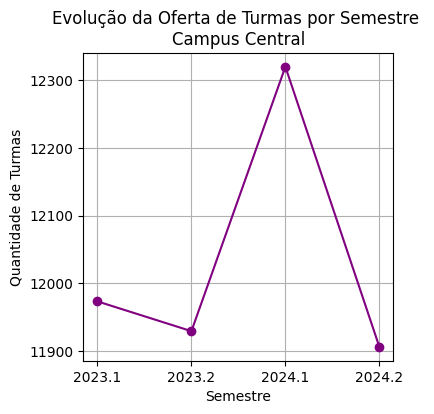

In [ ]:
df_natal = df[df['campus_turma'] == 'Campus Central'].copy() # Filter for 'Campus Central'

df_natal['semestre'] = df_natal['ano'].astype(str) + '.' + df_natal['periodo'].astype(str) # Criação do campo semestre

turmas_por_semestre = df_natal['semestre'].value_counts().sort_index() # Agrupa as turmas por semestre

plt.figure(figsize=(4, 4))
plt.plot(turmas_por_semestre.index, turmas_por_semestre.values, marker='o', linestyle='-', color='purple')
plt.xlabel('Semestre')
plt.ylabel('Quantidade de Turmas')
plt.title('Evolução da Oferta de Turmas por Semestre \nCampus Central')
plt.grid(True)
plt.show()

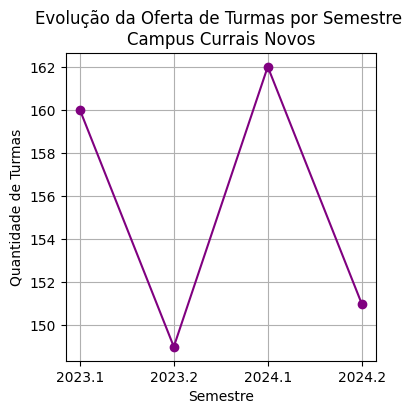

In [ ]:
df_natal = df[df['campus_turma'] == 'Campus Currais Novos'].copy()

df_natal['semestre'] = df_natal['ano'].astype(str) + '.' + df_natal['periodo'].astype(str) # Criação do campo semestre

turmas_por_semestre = df_natal['semestre'].value_counts().sort_index() # Agrupa as turmas por semestre

plt.figure(figsize=(4, 4))
plt.plot(turmas_por_semestre.index, turmas_por_semestre.values, marker='o', linestyle='-', color='purple')
plt.xlabel('Semestre')
plt.ylabel('Quantidade de Turmas')
plt.title('Evolução da Oferta de Turmas por Semestre \nCampus Currais Novos')
plt.grid(True)
plt.show()

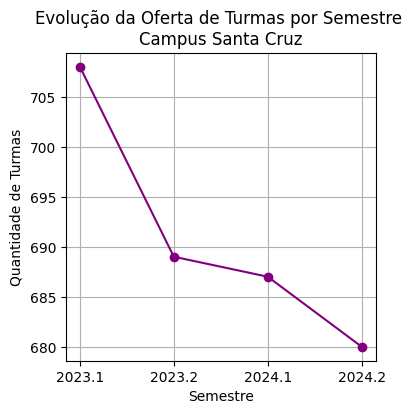

In [ ]:
df_natal = df[df['campus_turma'] == 'Campus Santa Cruz'].copy()

df_natal['semestre'] = df_natal['ano'].astype(str) + '.' + df_natal['periodo'].astype(str) # Criação do campo semestre

turmas_por_semestre = df_natal['semestre'].value_counts().sort_index() # Agrupa as turmas por semestre

plt.figure(figsize=(4, 4))
plt.plot(turmas_por_semestre.index, turmas_por_semestre.values, marker='o', linestyle='-', color='purple')
plt.xlabel('Semestre')
plt.ylabel('Quantidade de Turmas')
plt.title('Evolução da Oferta de Turmas por Semestre \nCampus Santa Cruz')
plt.grid(True)
plt.show()

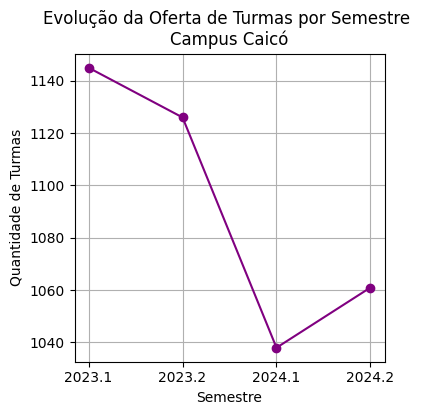

In [ ]:
df_natal = df[df['campus_turma'] == 'Campus Caicó'].copy()

df_natal['semestre'] = df_natal['ano'].astype(str) + '.' + df_natal['periodo'].astype(str) # Criação do campo semestre

turmas_por_semestre = df_natal['semestre'].value_counts().sort_index() # Agrupa as turmas por semestre

plt.figure(figsize=(4, 4))
plt.plot(turmas_por_semestre.index, turmas_por_semestre.values, marker='o', linestyle='-', color='purple')
plt.xlabel('Semestre')
plt.ylabel('Quantidade de Turmas')
plt.title('Evolução da Oferta de Turmas por Semestre \nCampus Caicó')
plt.grid(True)
plt.show()

É possível notar que cada campus possui sua própria dinâmica de oferta por turmas em certos semestres. Enquanto a oferta do Campus Central é menos em 2024.2 se comparado a 2023.2, em Currais Novos esses valores não se alteraram muito durante os dois últimos anos, o que pode indicar uma certa estabilidade de oferta, esperada para um campus de menor porte. Já em Santa Cruz, observa-se uma queda gradual e cronológica da oferta de turmas, o que pode estar indicando uma baixa procura pelos cursos. Esse dado pode ser cruzado com outras bases de dados como a do INEP, para provar ou refutar essa hipótese através da observação da nota de corte nos cursos deste campus ao longo dos anos.

Em Caicó, diferentemente de Natal e Currais Novos, observa-se uma oferta maior de turmas nos segundos semestres de cada ano, em comparação com os primeiros semestres. Isso pode indicar que nesse campus ingressam mais alunos no meio do ano do que no início.

É interessante fazer essa análise separadamente, para perceber que cada campus da UFRN possui suas próprias nuances, demandas e necessidades. Observar esses dados de forma conjunta pode dar a falsa impressão de homogeneidade que é majoritariamente causada pelo Campus Central, a quem se deve a maioria dos dados presentes nas bases estudadas.

#### Relação entre quantidade de solicitações e turno

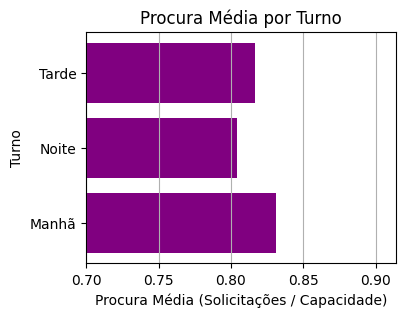

In [ ]:
df_filtered = df[(df['total_solicitacoes'] > 0) & (df['capacidade_aluno'] > 0)].copy()

def get_turno(descricao_horario):
    if 'M' in descricao_horario:
        return 'Manhã'
    elif 'T' in descricao_horario:
        return 'Tarde'
    elif 'N' in descricao_horario:
        return 'Noite'
    else:
        return 'Outro'

df_filtered['turno'] = df_filtered['descricao_horario'].apply(get_turno) # Aplica get_turno para cada valor em descricao_horario
df_filtered['procura_media'] = df_filtered['total_solicitacoes'] / df_filtered['capacidade_aluno'] # Calcula a procura média

procura_por_turno = df_filtered.groupby('turno')['procura_media'].mean()
procura_por_turno.reindex(['Manhã', 'Tarde', 'Noite'])

plt.figure(figsize=(4, 3))
plt.barh(procura_por_turno.index, procura_por_turno.values, color='purple')
plt.ylabel('Turno')
plt.xlabel('Procura Média (Solicitações / Capacidade)')
plt.title('Procura Média por Turno')
plt.grid(axis='x')
plt.xlim(0.7, max(procura_por_turno.values) * 1.1) # Define o valor base para 0.7
plt.show()

O gráfico acima mostra a procura média por turmas em cada um dos turnos de ensino. Apesar de não ser uma diferença expressiva, é notório que há uma preferência dos alunos por alunas durante o período da manhã e da tarde, sendo o período da noite aquele com a menor procura média.

Estas são apenas algumas das análises que podemos fazer a partir dos dados que utilizamos. É interessante que os resultados da etapa de análise exploratória de dados sejam compartilhados com outras pessoas, pois elas podem também contribuir para que os *insights* causados pela observação dos gráficos leve a caminhos e interpretações diferentes, abrindo espaço para discussões e análises ainda mais elaboradas.

## Atividade 3 - Data Mining e Clusterização
### Análise da demanda por carga horária
Vamos revisitar um dos gráficos que plotamos na seção interior, que trata da procura por turmas de docentes internos da UFRN. Iremos pegar essas colunas de dados e, com a ajuda do algoritmo k-means, tentar visualizar separações desses dados em grupos distintos.

In [ ]:
# Etapa de pré tratamento dos dados

# Filtra valores maiores que 0 para "total_solicitacoes" e "capacidade_aluno"
# Esses filtros precisam ser feitos pois, na fase de limpeza, definimos -1 como o placeholder para valores nulos

turmas_siape = df[(df['siape'] != 0) & (df['total_solicitacoes'] > 0) & (df['capacidade_aluno'] > 0)].copy()
turmas_siape['procura_media'] = turmas_siape['total_solicitacoes'] / turmas_siape['capacidade_aluno'] # Média de procura pelas turmas

# Select only the numeric columns needed for clustering
data = turmas_siape[['ch_dedicada_periodo', 'procura_media']].copy()


# Padronização dos dados
scaler = StandardScaler() # Cria um objeto scaler usado na padronização
data_scaled = scaler.fit_transform(data) # Normaliza os dados contidos em "data"

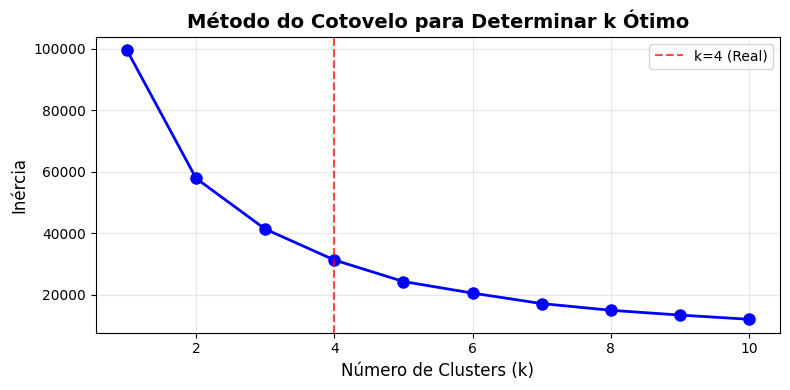

In [ ]:
# Etapa de aplicação da regra do cotovelo
k_range = range(1, 11) # Definimos o intervalo de interação para "k"
inertias = []

for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Criação de um objeto k-means com o valor de "k" especificado
  kmeans.fit(data_scaled) # Treinamento do modelo usando os dados normalizados
  inertias.append(kmeans.inertia_) # Adiciona o valor de inércia para o modelo usado em um vetor

plt.figure(figsize=(8,4))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inércia', fontsize=12)
plt.title('Método do Cotovelo para Determinar k Ótimo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='k=4 (Real)')
plt.legend()
plt.tight_layout()
plt.show()

Pelo método do cotovelo, chegamos à conclusão de que o valor k=4 é o mais ideal para esta situação.

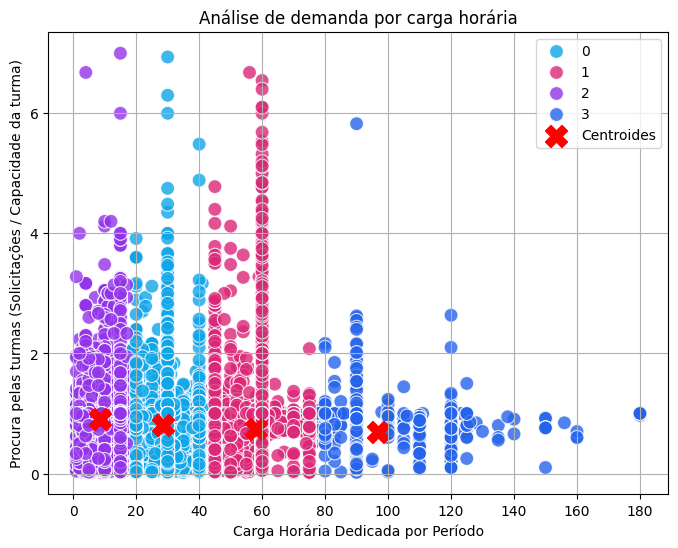

In [ ]:
# Aplicar K-Means com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data)
data['cluster'] = clusters

# Filtra os dados para carga horária menor que 200 e procura media menor que 8
data_filtered = data[(data['ch_dedicada_periodo'] < 200) & (data['procura_media'] < 8)].copy()

# Define a custom color palette
custom_palette = ["#0ea5e9", "#db2777", "#9333ea", "#2563eb"]

# Gerar o gráfico de clusterização
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='ch_dedicada_periodo',
    y='procura_media',
    hue='cluster',
    data=data_filtered,
    palette=custom_palette,
    s=100,
    alpha=0.8,
    legend='full'
)
# Plotar os centroides
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=250, marker='X', label='Centroides')
plt.title('Análise de demanda por carga horária')
plt.xlabel('Carga Horária Dedicada por Período')
plt.ylabel('Procura pelas turmas (Solicitações / Capacidade da turma)')
plt.legend()
plt.grid(True)

# Adicionar mais marcações nos eixos
plt.xticks(np.arange(0, data_filtered['ch_dedicada_periodo'].max() + 1, 20)) # Adiciona marcações a cada 20 unidades no eixo x
plt.yticks(np.arange(0, data_filtered['procura_media'].max() + 1, 2)) # Adiciona marcações a cada 2 unidades no eixo y


plt.show()

O gráfico acima exibe a designação detectada pelo algoritmo k-means. A regra do cotovelo indica que a utilização de um valor de k=4 é o ideal para a análise que pretendemos fazer.

Podemos enxergar algumas características entre os grupos:


*   **Grupo 2 (roxo)**: é o grupo das turmas com carga horária máxima de 20 horas que possui uma alta procura;
*   **Grupo 0 (ciano)**: é o grupo das turmas com carga horária entre 20 e 45 horas que possui uma alta procura, com destaque para as disciplinas de 30 horas;
*   **Grupo 1 (rosa)**: é o grupo das turmas com carga horária entre 45 e 80 horas que possui uma alta procura, com destaque para as disciplinas de 60 horas;
*   **Grupo 3 (azul)**: é o grupo das turmas com carga horária acima de 80 horas que possui procura moderada para baixa, com um leve destaque para as disciplinas de 90 horas.



### Análise da demanda por ensino individual em cada setor da UFRN
Uma implementação futura para as análises de dados propostas aqui seria com relação às turmas de ensino individual da UFRN (classificadas na coluna `tipo`). No entanto, a base de dados atual carece de uma informação importante: o setor de aulas em que cada turma está sendo ofertada. Uma forma de contornar esse problema seria utilizar a [base de dados de componentes curriculares](https://dados.ufrn.br/dataset/componentes-curriculares/resource/9a3521d2-4bc5-4fda-93f0-f701c8a20727) da UFRN, que oferece esta informação que precisamos. O método para obtenção desse dado seguiria o seguinte processo:

1.   Download da base de dados bruta;
2.   Importação a base de dados para um DataFrame Pandas;
3. Filtragem para os campos `id_componente` e `unidade_responsavel`
4. Inner join entre este DataFrame e o DataFrame atual de trabalho, que também possui o campo `id_componente`.

A partir daí, o procedimento seguiria o outro passo a passo para a criação de clusters k-means, que auxiliariam na visualização destes dados, possibilitando a visualização de quais setores da UFRN demandam mais ensino individual, bem como a reflexão dos motivos pelos quais isto acontece e que medidas podem ser tomadas a respeito.



### Análise de tipos de turma

Vamos agora tentar analisar os tipos de turma que existem na UFRN. Para isso, nos basearemos em duas variáveis: a capacidade de alunos para aquela disciplina e a quantidade de aulas que foram lançadas por ela durante o período letivo.

In [ ]:
# Obtenção de dados
data = df[['capacidade_aluno', 'qtd_aulas_lancadas']].copy()
data = data[(data['capacidade_aluno'] > 0) & (data['qtd_aulas_lancadas'] > 0)].copy()


# Normalização dos dados
scaler = StandardScaler() # Cria um objeto scaler usado na padronização
data_norm = scaler.fit_transform(data) # Normaliza os dados contidos em "data"

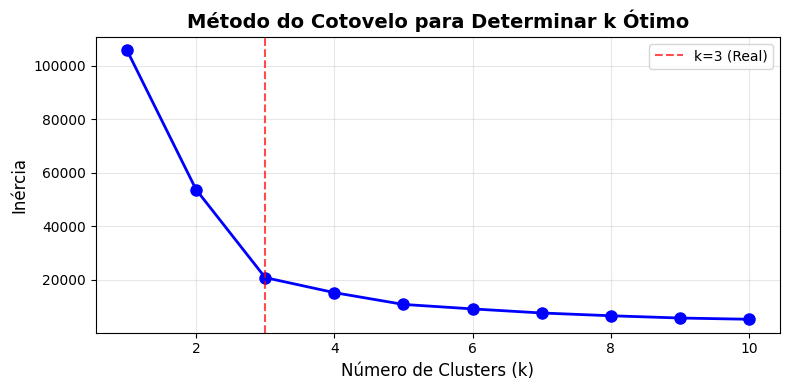

In [ ]:
# Aplicação da regra do cotovelo
k_range = range(1, 11) # Definimos o intervalo de interação para "k"
inertias = []

for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Criação de um objeto k-means com o valor de "k" especificado
  kmeans.fit(data_norm) # Treinamento do modelo usando os dados normalizados
  inertias.append(kmeans.inertia_) # Adiciona o valor de inércia para o modelo usado em um vetor

plt.figure(figsize=(8,4))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inércia', fontsize=12)
plt.title('Método do Cotovelo para Determinar k Ótimo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3 (Real)')
plt.legend()
plt.tight_layout()
plt.show()

Através do método do cotovelo, concluímos que k=3 é o valor ideal a ser usado nesta situação.

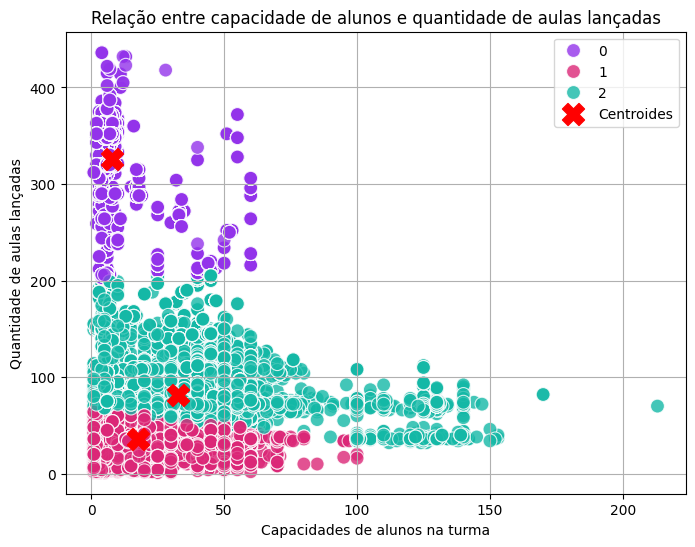

In [ ]:
# Aplicar K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data)
data['cluster'] = clusters

# Define a custom color palette
custom_palette = ["#9333ea", "#db2777", "#14b8a6"]

# Gerar o gráfico de clusterização
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='capacidade_aluno',
    y='qtd_aulas_lancadas',
    hue='cluster',
    data=data,
    palette=custom_palette,
    s=100,
    alpha=0.8,
    legend='full'
)
# Plotar os centroides
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=250, marker='X', label='Centroides')
plt.title('Relação entre capacidade de alunos e quantidade de aulas lançadas')
plt.xlabel('Capacidades de alunos na turma')
plt.ylabel('Quantidade de aulas lançadas')
plt.legend()
plt.grid(True)


plt.show()

Ao analisar o gráfico acima, podemos constatar que existem grupos de turmas com dinâmicas diferentes, que podem ser classificadas da seguinte forma:


*   Cluster 2 (verde): É o cluster que representa as turmas mais volumosas da UFRN, com aulas que provavelmente são lecionadas em auditórios para dar conta da grande demanda de alunos. Sua baixa quantidade de aulas pode indicar se tratar de uma disciplina de curta duração. Caso seja optativa, trata-se de uma disciplina muito visada mesmo por alunos de outros departamentos;
*   Cluster 0 (roxo): São turmas que possuem uma relativa baixa capacidade de alunos e uma quantidade alta de aulas lançadas. Este é, provavelmente, o grupo no qual estão inseridos os componentes curriculares mais "convencionais", ministrados em salas de aula que raramente ultrapassam 50 alunos;
* Cluster 1 (rosa): Este cluster representa turmas de atividades complementares: TCC's, projetos de extensão e outras atividades com menos encontros formais.

Análises desse tipo podem auxiliar a gestão da UFRN a tomarem uma maior decisão sobre quais disciplinas precisam de mais atenção, ajudando, por exemplo, na tomada de decisão para realocar salas de aula grandes que contém poucos alunos e salas pequenas que contém muitos alunos. Apesar disso, a análise feita ainda é bastante inconclusiva, pela proximidade entre as amostras estudadas. É possível que, utilizando um algoritmo mais robusto de clusterização, os resultados acabem se tornando mais agradáveis.



## Atividade 4 - Testes e Hipóteses

Nesta seção, iremos discutir brevemente sobre testes estatísticos e métodos formais para tirar conclusões a partir dos dados que temos a nossa disposição. Para isso, usaremos alguns métodos paramétricos e não paramétricos para comparar diferentes grandezas e estabelecer uma relação entre elas através de hipóteses.

### Capacidade de alunos nas turmas do campus Caicó e Santa Cruz.

Vamos fazer uma comparação entre a capacidade de alunos nas turmas do campus Caicó e Santa Cruz da UFRN. Aplicaremos dois testes: um paramétrico (Teste t) e um não paramétrico (Teste de Mann-Whitney U). Para cada um estabeleceremos duas hipóteses, a saber:

**Teste t**:
- H0: Não há diferença significativa na média de capacidade de alunos nas turmas dos campus Caicó e Santa Cruz;
- Ha: Há diferença significativa na média de capacidade de alunos nas turmas dos campus Caicó e Santa Cruz.

**Teste de Mann-Whitney U**:
- H0: As distribuições de capacidade de alunos por turma são iguais para os dois grupos;
- Ha: As distribuições de capacidade de alunos por turma são diferentes para os dois grupos.

Os resultados para ambos os testes estão descritos a seguir.

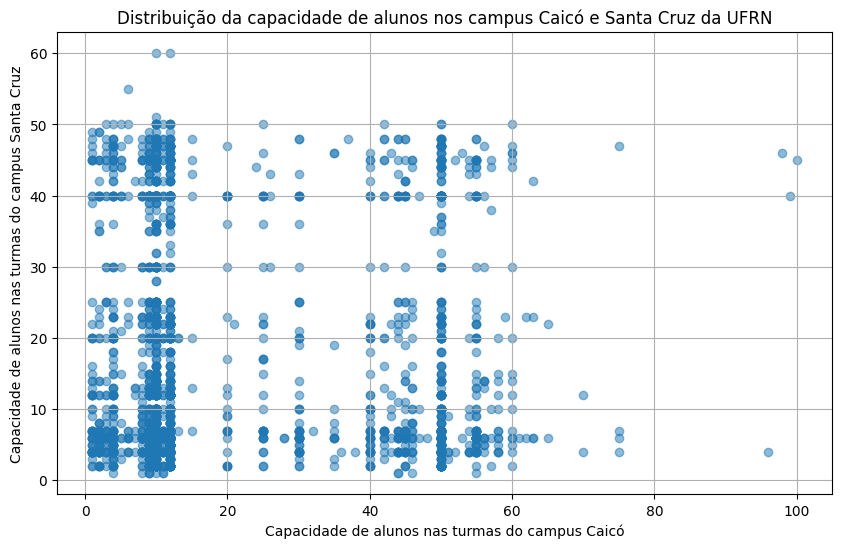

In [ ]:
turmas_ca = df[df['campus_turma'] == 'Campus Caicó'].copy()
turmas_sc = df[df['campus_turma'] == 'Campus Santa Cruz'].copy()

min_samples = min(len(turmas_ca), len(turmas_sc))

capacidade_ca = turmas_ca['capacidade_aluno'].sample(n=min_samples, random_state=42)
capacidade_sc = turmas_sc['capacidade_aluno'].sample(n=min_samples, random_state=42)

plt.figure(figsize=(10, 6))
plt.scatter(capacidade_ca, capacidade_sc, alpha=0.5)
plt.xlabel('Capacidade de alunos nas turmas do campus Caicó')
plt.ylabel('Capacidade de alunos nas turmas do campus Santa Cruz')
plt.title('Distribuição da capacidade de alunos nos campus Caicó e Santa Cruz da UFRN')
plt.grid(True)
plt.show()

In [ ]:
#---------------------------------------------------
# Teste 1: Teste t para amostras independentes (Paramétrico)
#---------------------------------------------------
# H0: Não há diferença significativa na média de capacidade de alunos nas turmas dos campus Caicó e Santa Cruz
# Ha: Há diferença significativa na média de capacidade de alunos nas turmas dos campus Caicó e Santa Cruz
print("--- Teste t (Comparação de Médias) ---")
alpha = 0.05
t_stat, p_valor_t = stats.ttest_ind(capacidade_ca, capacidade_sc)

print(f"Estatística t: {t_stat:.4f}")
print(f"P-valor do Teste t: {p_valor_t:.4f}")

if p_valor_t < alpha:
    print("Resultado: Rejeitamos a hipótese nula (H0). \nHá diferença significativa na média de capacidade de alunos nas turmas dos campus Caicó e Santa Cruz.\n")
else:
    print("Resultado: Falhamos em rejeitar a hipótese nula (H0). \nNão há diferença significativa na média de capacidade de alunos nas turmas dos campus Caicó e Santa Cruz.\n")

--- Teste t (Comparação de Médias) ---
Estatística t: 6.5052
P-valor do Teste t: 0.0000
Resultado: Rejeitamos a hipótese nula (H0). 
Há diferença significativa na média de capacidade de alunos nas turmas dos campus Caicó e Santa Cruz.



In [ ]:
#-----------------------------------------------------------
# Teste 2: Teste de Mann-Whitney U (Não-Paramétrico) - TESTE BILATERAL (TWO-SIDED)
#-----------------------------------------------------------
print("--- Teste de Mann-Whitney U (Comparação de Distribuições) ---")
# H0: As distribuições de capacidade de alunos por turma são iguais para os dois grupos.
# Ha: As distribuições de capacidade de alunos por turma são diferentes para os dois grupos.

u_stat, p_valor_mw = stats.mannwhitneyu(capacidade_ca, capacidade_sc, alternative='two-sided') # 'two-sided' é o padrão

print(f"Estatística U: {u_stat:.4f}")
print(f"P-valor do Teste de Mann-Whitney (Bilateral): {p_valor_mw:.4f}")

if p_valor_mw < alpha:
    print("Resultado: Rejeitamos a hipótese nula (H0). \nAs distribuições de capacidade de alunos por turma são diferentes para os dois grupos.")
else:
    print("Resultado: Falhamos em rejeitar a hipótese nula (H0). Não há evidência de uma diferença significativa entre as distribuições de capacidade de alunos nos dois grupos.")


--- Teste de Mann-Whitney U (Comparação de Distribuições) ---
Estatística U: 4606398.5000
P-valor do Teste de Mann-Whitney (Bilateral): 0.0000
Resultado: Rejeitamos a hipótese nula (H0). 
As distribuições de capacidade de alunos por turma são diferentes para os dois grupos.


### Aulas cadastradas por turno

Nesta nova análise, queremos nos questionar o seguinte: existe diferença entre a quantidade de aulas cadastradas para cada turno na UFRN. Para tal, como estamos trabalhando com três grupos (turno matutino, vespertino e noturno), precisamos utilizar um método de análise que suporte essa estrutura. Dentre várias, podemos escolher a ANOVA, que busca relações de média numérica com mais de dois grupos.

Sendo assim, podemos definir novamente nossas hipóteses nula (H0) e alternativa (Ha) da seguinte forma:

- H0: Não existe diferença significativa na média da quantidade de aulas lançadas por turno;
- Ha: Existe diferença significativa na média da quantidade de aulas lançadas por turno.

Tendo isso em mãos, podemos iniciar a preparação do nosso teste.

In [ ]:
# Criação de uma nova coluna "turno" no DataFrame
def get_turno(descricao_horario):
    if 'M' in descricao_horario:
        return 'Manhã'
    elif 'T' in descricao_horario:
        return 'Tarde'
    elif 'N' in descricao_horario:
        return 'Noite'
    else:
        return 'Outro'

data = df.copy()
data['turno'] = data['descricao_horario'].apply(get_turno)

/tmp/ipython-input-465029442.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='qtd_aulas_lancadas', y='turno', palette='plasma')


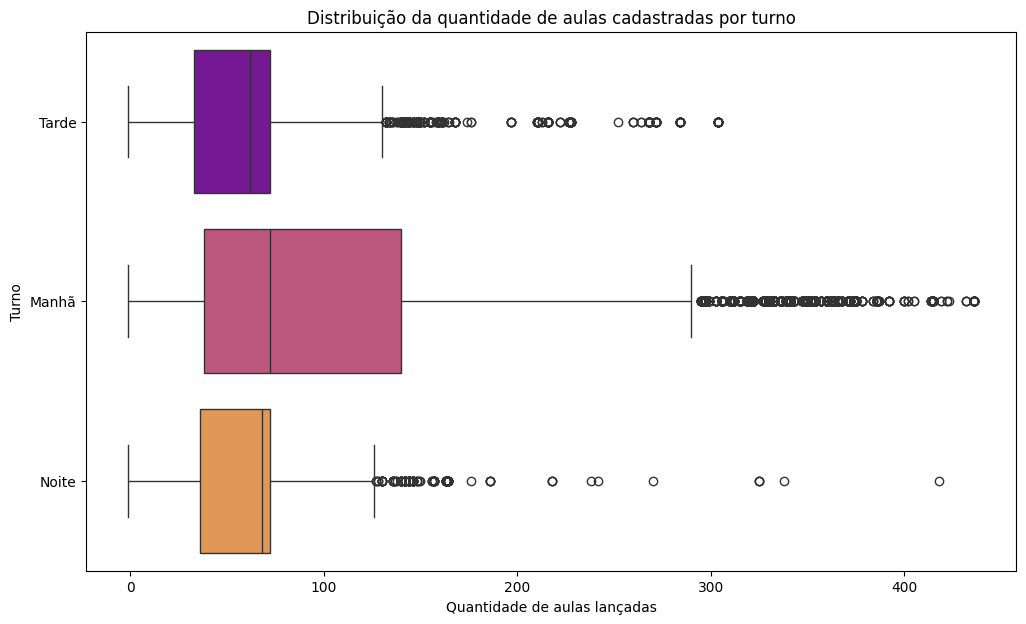

In [ ]:
# 1. Visualização com Boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(data=data, x='qtd_aulas_lancadas', y='turno', palette='plasma')
plt.title('Distribuição da quantidade de aulas cadastradas por turno')
plt.xlabel('Quantidade de aulas lançadas')
plt.ylabel('Turno')
plt.show()

In [ ]:
# 2. Preparando os dados para o teste ANOVA
# A função f_oneway espera cada grupo como um argumento separado
turnos = data['turno'].unique()
amostras = [data[data['turno'] == turno]['qtd_aulas_lancadas'] for turno in turnos]

# 3. Realizando o Teste ANOVA
f_stat, p_valor_anova = stats.f_oneway(*amostras)

print(f"Estatística F: {f_stat:.4f}")
print(f"P-valor da ANOVA: {p_valor_anova:.10f}")

# H0: Não existe diferença significativa na média da quantidade de aulas lançadas por turno
# Ha: Existe diferença significativa na média da quantidade de aulas lançadas por turno

# Interpretação
if p_valor_anova < alpha:
    print("\nRejeitamos a Hipótese Nula (H0).")
    print("Existe uma diferença estatisticamente significativa na média da quantidade de aulas lançadas por turno.")
else:
    print("\nFalhamos em Rejeitar a Hipótese Nula (H0).")
    print("Não há evidências de uma diferença significativa na média da quantidade de aulas lançadas por turno.")

Estatística F: 3260.7025
P-valor da ANOVA: 0.0000000000

Rejeitamos a Hipótese Nula (H0).
Existe uma diferença estatisticamente significativa na média da quantidade de aulas lançadas por turno.


### Turmas ofertadas em início de semestre

Uma outra análise que poderia ser feita seria para confirmar o gráfico exibido durante a atividade 2, que mostra um aumento significativo na oferta por disciplinas durante os meses de início de semestre (Fevereiro, Março, Agosto e Setembro). No entanto, não consegui encontrar um método que se encaixasse bem com a natureza desta análise.

Trata-se de uma comparação entre dois grupos: o grupo dos meses referentes ao início de semestre letivo e o grupo dos meses restantes. A partir dessa separação, deve se comparar a ocorrência de turmas. A ideia inicial de se considerar a quantidade de aulas lançadas foi descartada, pois uma maior quantidade de aulas não necessariamente significa uma quantidade maior de turmas (tendo em vista as cargas horárias divergentes).

Outra possibilidade levantada foi a de considerar a soma dos registros, mas isto nos leva a outra questão: seria mesmo necessário utilizar esse tipo de análise estatística? Em se tratando de dois grupos `meses_inicio_semestre` e `meses_nao_inicio_semestre`, onde cada um possui como valor o somatório dos registros em que os meses são condizente com os critérios especificados, o resultado são simplesmente dois valores numéricos. A partir daí, a hipótese nula pode ser simplesmente descartada ou não apenas verificando se `meses_nao_inicio_semestre > 0.05 * meses_inicio_semestre`. Sendo assim, a ideia da análise estatística parece, neste caso em específico, um desperdício de trabalho.